# Option 2: Geological Image Simalarity

## BACKGROUND
A geology research company wants to create a tool for identifying interesting patterns in their imagery data. This tool will possess a search capability whereby an analyst provides an image of interest and is presented with other images which are similar to it.
## GOAL
Your task is to create the machine learning component for this image similarity application. The machine learning
model should return the top K images that are most similar to this image based on a single image input.
## DATA
Link to data: https://www.kaggle.com/tanyadayanand/geological-image-similarity

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from collections import defaultdict
from glob import glob
from pathlib import Path
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.preprocessing.dataset_utils import index_directory, get_training_or_validation_split

In [2]:
data_dir = Path('../data/geological_similarity')

In [3]:
file_paths, labels, class_names = index_directory(str(data_dir), "inferred", formats='.jpg')
class_names

Found 29998 files belonging to 6 classes.


['andesite', 'gneiss', 'marble', 'quartzite', 'rhyolite', 'schist']

In [4]:
IMG_CHANNELS = 3
def read_and_preprocess(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    return np.array(img)/255.0

In [5]:
train_path, train_labels = get_training_or_validation_split(file_paths, labels, 0.2, 'training')
test_path, test_labels = get_training_or_validation_split(file_paths, labels, 0.2, 'validation')

Using 23999 files for training.
Using 5999 files for validation.


In [6]:
train_data = np.array([read_and_preprocess(path) for path in train_path])
test_data = np.array([read_and_preprocess(path) for path in test_path])

In [7]:
class_idx_to_train_idxs = defaultdict(list)
for y_train_idx, y in enumerate(train_labels):
    class_idx_to_train_idxs[y].append(y_train_idx)
    
class_idx_to_test_idxs = defaultdict(list)
for y_test_idx, y in enumerate(test_labels):
    class_idx_to_test_idxs[y].append(y_test_idx)

In [8]:
num_classes = 6

In [9]:
class AnchorPositivePairs(keras.utils.Sequence):
    def __init__(self, num_batchs):
        self.num_batchs = num_batchs

    def __len__(self):
        return self.num_batchs

    def __getitem__(self, _idx):
        x = np.empty((2, num_classes, height_width, height_width, 3), dtype=np.float32)
        for class_idx in range(num_classes):
            examples_for_class = class_idx_to_train_idxs[class_idx]
            anchor_idx = random.choice(examples_for_class)
            positive_idx = random.choice(examples_for_class)
            while positive_idx == anchor_idx:
                positive_idx = random.choice(examples_for_class)
            x[0, class_idx] = train_data[anchor_idx]
            x[1, class_idx] = train_data[positive_idx]
        return x

In [10]:
def show_collage(examples):
    box_size = height_width + 2
    num_rows, num_cols = examples.shape[:2]

    collage = Image.new(
        mode="RGB",
        size=(num_cols * box_size, num_rows * box_size),
        color=(250, 250, 250),
    )
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            array = (np.array(examples[row_idx, col_idx]) * 255).astype(np.uint8)
            collage.paste(
                Image.fromarray(array), (col_idx * box_size, row_idx * box_size)
            )

    # Double size for visualisation.
    collage = collage.resize((4 * num_cols * box_size, 4 * num_rows * box_size))
    return collage


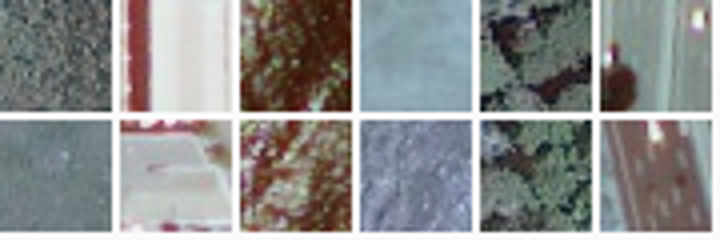

In [11]:
height_width = 28

examples = next(iter(AnchorPositivePairs(num_batchs=1)))

show_collage(examples)

## Embedding model

In [12]:
class EmbeddingModel(keras.Model):
    def train_step(self, data):
        # Note: Workaround for open issue, to be removed.
        if isinstance(data, tuple):
            data = data[0]
        anchors, positives = data[0], data[1]

        with tf.GradientTape() as tape:
            # Run both anchors and positives through model.
            anchor_embeddings = self(anchors, training=True) #forward pass
            positive_embeddings = self(positives, training=True) #forward pass

            # Calculate cosine similarity between anchors and positives. As they have
            # been normalised this is just the pair wise dot products.
            similarities = tf.einsum(
                "ae,pe->ap", anchor_embeddings, positive_embeddings
            )

            # Since we intend to use these as logits we scale them by a temperature.
            # This value would normally be chosen as a hyper parameter.
            temperature = 0.2
            similarities /= temperature

            # We use these similarities as logits for a softmax. The labels for
            # this call are just the sequence [0, 1, 2, ..., num_classes] since we
            # want the main diagonal values, which correspond to the anchor/positive
            # pairs, to be high. This loss will move embeddings for the
            # anchor/positive pairs together and move all other pairs apart.
            sparse_labels = tf.range(num_classes)
            loss = self.compiled_loss(sparse_labels, similarities)

        # Calculate gradients and apply via optimizer.
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(sparse_labels, similarities)
        return {m.name: m.result() for m in self.metrics}

## An architecture that maps from an image to an embedding
###  normalize the embeddings so that we can use simple dot products (cosine similarity) to measure simliarity which is common in metric learning, 

In [13]:
inputs = layers.Input(shape=(height_width, height_width, 3))
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
embeddings = layers.Dense(units=8, activation=None)(x)
embeddings = tf.nn.l2_normalize(embeddings, axis=-1)

model = EmbeddingModel(inputs, embeddings)

Epoch 1/20
1000/1000 [==============================] - 4s 3ms/step - loss: 1.4730
Epoch 2/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.8689
Epoch 3/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5675A: 0s - lo
Epoch 4/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3954
Epoch 5/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3830
Epoch 6/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3486
Epoch 7/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.3169
Epoch 8/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2911
Epoch 9/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2963
Epoch 10/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2869
Epoch 11/20
1000/1000 [==============================] - 3s 3ms/step - loss: 0.2699
Epoch 12/20
1000/1000 [==============================] - 3s 3ms/step - loss

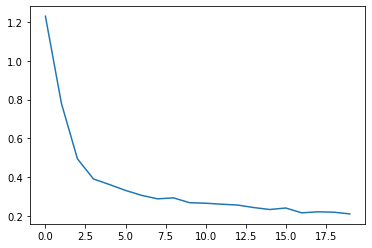

In [14]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

history = model.fit(AnchorPositivePairs(num_batchs=1000), epochs=20)

plt.plot(history.history["loss"])
plt.show()

## Testing

In [15]:
near_neighbors_per_example = 5

embeddings = model.predict(test_data)
gram_matrix = np.einsum("ae,pe->ap", embeddings, embeddings)
near_neighbors = np.argsort(gram_matrix.T)[:, -(near_neighbors_per_example + 1) :]

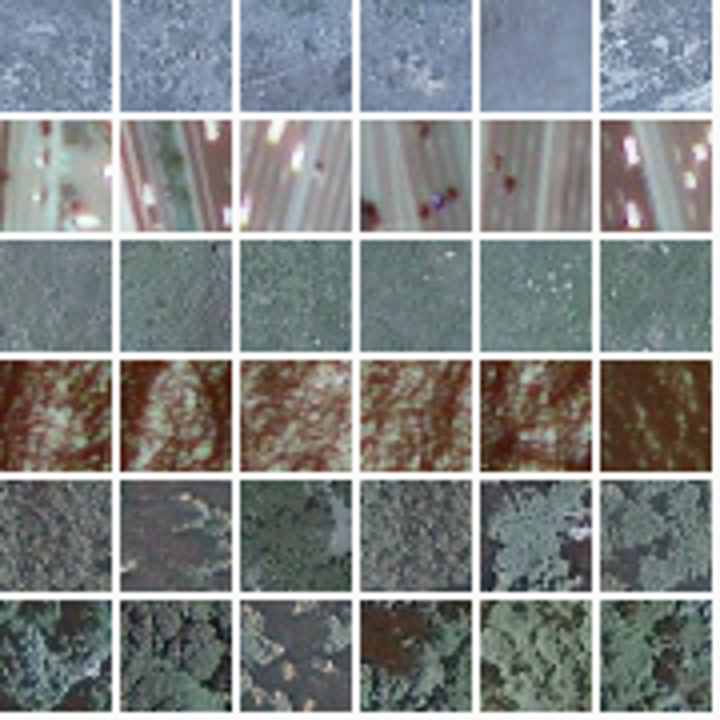

In [26]:
num_collage_examples = 6
examples = np.empty(
    (
        num_collage_examples,
        near_neighbors_per_example + 1,
        height_width,
        height_width,
        3,
    ),
    dtype=np.float32,
)
for row_idx in range(num_collage_examples):
    examples[row_idx, 0] = test_data[row_idx]
    anchor_near_neighbors = reversed(near_neighbors[row_idx][:-1])
    for col_idx, nn_idx in enumerate(anchor_near_neighbors):
        examples[row_idx, col_idx + 1] = test_data[nn_idx]

show_collage(examples)

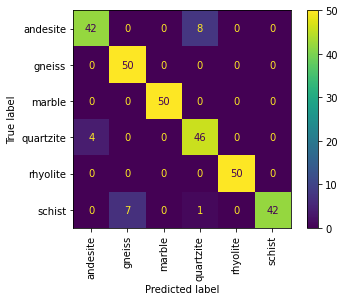

In [19]:
confusion_matrix = np.zeros((num_classes, num_classes))

# For each class.
for class_idx in range(num_classes):
    # Consider 10 examples.
    example_idxs = class_idx_to_test_idxs[class_idx][:10]
    for y_test_idx in example_idxs:
        # And count the classes of its near neighbours.
        for nn_idx in near_neighbors[y_test_idx][:-1]:
            nn_class_idx = test_labels[nn_idx]
            confusion_matrix[class_idx, nn_class_idx] += 1

# Display a confusion matrix.
labels = [
    "andesite",
    "gneiss",
    "marble",
    "quartzite",
    "rhyolite",
    "schist",
]
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)
disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
plt.show()